# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [11]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

# full model
accuracy_full = accuracy_score(yf_test, ypred_full)
precision_full = precision_score(yf_test, ypred_full)
recall_full = recall_score(yf_test, ypred_full)

# reduced model 
accuracy_reduced = accuracy_score(yr_test, ypred_reduced)
precision_reduced = precision_score(yr_test, ypred_reduced)
recall_reduced = recall_score(yr_test, ypred_reduced)

In [12]:
print('Full Accuracy:', accuracy_full)
print('Full Precision:', precision_full)
print('Full Recall:', recall_full)

Full Accuracy: 0.7233333333333334
Full Precision: 0.7333333333333333
Full Recall: 0.678082191780822


In [13]:
print('Reduced Accuracy:', accuracy_reduced)
print('Reduced Precision:', precision_reduced)
print('Reduced Recall:', recall_reduced)

Reduced Accuracy: 0.7166666666666667
Reduced Precision: 0.7364341085271318
Reduced Recall: 0.6506849315068494


## 4) Plot ROC and Precision–Recall Curves

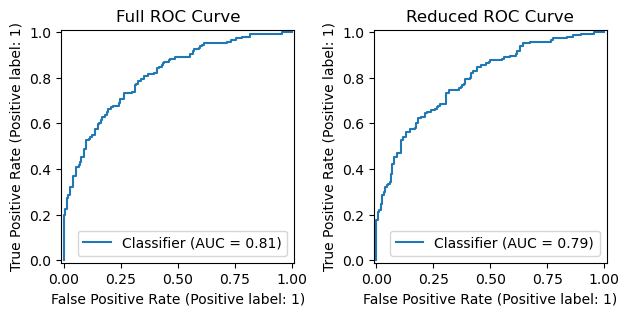

In [21]:
# TODO: Plot ROC and PR curves for both models on shared axes

# ROC Plots
fig, axes = plt.subplots(1,2)
RocCurveDisplay.from_predictions(yf_test, yprob_full, ax=axes[0])
axes[0].set_title('Full ROC Curve')
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, ax=axes[1])
axes[1].set_title('Reduced ROC Curve')

plt.tight_layout()


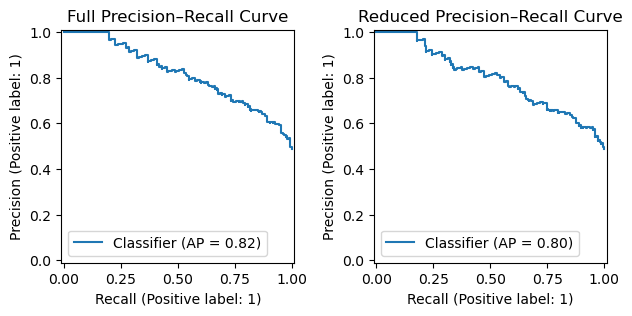

In [22]:
# Precision Recall Plots
fig, axes = plt.subplots(1,2)
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, ax=axes[0])
axes[0].set_title("Full Precision–Recall Curve")

PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, ax=axes[1])
axes[1].set_title("Reduced Precision–Recall Curve")


plt.tight_layout()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

### Answers
1. The Full model has both a higher ROC-AUC and PR-AUC. This implies that PWAT is an important factor for this model.
2. Comparing accuracy and recall for both models, the full data has higher values, showing it would be best to maximize event detection. However, the reduced model has a higher precision value and would be best to minimize false alarms. 